In [0]:
## @@ Author: Shashank Shekhar
## Student Id: 200262327
## Unity Id: sshekha4

In [0]:
# Below project is an attempt to predict the crime rate in the city of Chicago using different models.
### Tasks:
## Merge the two given datasets - Social-Economic Dataset and Chicago Crime Dataset based on a common attribute
## Impute / Remove missing data
## Remove not contributing columns based on some analysis
## Generate new features relevant to the prediction, if needed
## Do a multicollinearity and other checks wrt to input data
## Make sure that categorical variables are properly encoded before providing it to the classifier
## Train different models for predicting crimes in the city based on inputs provided

In [1]:
## Making all the required imports
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy
import sklearn
import tensorflow as tf
import keras
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import warnings
from numpy import array

Using TensorFlow backend.
C:\Users\sshek\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
## Mounting Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Copy Chicago Social-Economic data to google colab from google drive
!cp 'gdrive/My Drive/Colab Notebooks/Chicago_Census_SociaEcon_CommArea_2008_2012.csv' .

In [4]:
# Copy zipped Chicago Crime data to google colab from google drive and unzip
!cp gdrive/My\ Drive/Colab\ Notebooks/crimes-in-chicago.zip .
!unzip crimes-in-chicago.zip

Archive:  crimes-in-chicago.zip
  inflating: Chicago_Crimes_2001_to_2004.csv  
  inflating: Chicago_Crimes_2005_to_2007.csv  
  inflating: Chicago_Crimes_2008_to_2011.csv  
  inflating: Chicago_Crimes_2012_to_2017.csv  


In [9]:
## Read the required data from the CSV Files
chicago_crime_08_to_11 = pd.read_csv('./Chicago_Crimes_2008_to_2011.csv', error_bad_lines=False)
chicago_crime_12_to_17 = pd.read_csv('./Chicago_Crimes_2012_to_2017.csv', error_bad_lines=False)

b'Skipping line 1149094: expected 23 fields, saw 41\n'


In [0]:
## Merge the data from 2008 to 2012 year for analysis
chicago_crime_12 = chicago_crime_12_to_17[chicago_crime_12_to_17.Year == 2012]
chicago_crime_data = pd.concat([chicago_crime_08_to_11, chicago_crime_12])
## Read the required data from the CSV File
chicago_socia_econ = pd.read_csv('./Chicago_Census_SociaEcon_CommArea_2008_2012.csv')

In [11]:
# Printing shape of chicago_crime_data before dropping the duplicates
print(chicago_crime_data.shape)
# Dropping duplicate data from chicago_crime_data
chicago_crime_data.drop_duplicates(subset=['ID', 'Case Number'], inplace=True)
# Printing shape of chicago_crime_data after dropping the duplicates
print(chicago_crime_data.shape)
# Extract month from Date and create it as a seperate feature
chicago_crime_data['Month'] = pd.DatetimeIndex(chicago_crime_data['Date']).month

(3024380, 23)
(1876885, 23)


In [0]:
## Keeping the original chicago_crime_data as it is for later use
chicago_crime_data_dup = chicago_crime_data.copy()

In [19]:
# Removing columns from chicago_crime_data that are not required for crime prediction
chicago_crime_data_dup.drop(['Unnamed: 0', 'ID', 'Case Number', 'Date', 'Location Description', 'Block', 'IUCR', 'Description', 'Arrest', 'Domestic', 'Beat', 'District', 'Ward', 'FBI Code', 'X Coordinate', 'Y Coordinate',  'Year', 'Updated On', 'Latitude', 'Longitude', 'Location'], inplace=True, axis=1)
# Renaming the columns in chicago_crime_data 
chicago_crime_data_dup = chicago_crime_data_dup.rename(columns={'Community Area': 'Community Area Number'})
# Renaming the columns in chicago_socia_econ
chicago_socia_econ = chicago_socia_econ.rename(columns={'COMMUNITY AREA NAME': 'Community Area Name','PERCENT OF HOUSING CROWDED': '% Housing Crowded', 'PERCENT HOUSEHOLDS BELOW POVERTY': '% Households Below Poverty', 'PERCENT AGED 16+ UNEMPLOYED': '% Aged 16+ Unemployed', 'PERCENT AGED 25+ WITHOUT HIGH SCHOOL DIPLOMA': '% Aged 25+ Without High School Diploma', 'PERCENT AGED UNDER 18 OR OVER 64' : '% Aged >18 or <64', 'PER CAPITA INCOME ': 'Per Capita Income', 'HARDSHIP INDEX': 'Hardship Index'})
# Column names from both the tables below
print(chicago_crime_data_dup.columns.values)
print(chicago_socia_econ.columns.values)

['Primary Type' 'Community Area Number' 'Month']
['Community Area Number' 'Community Area Name' '% Housing Crowded'
 '% Households Below Poverty' '% Aged 16+ Unemployed'
 '% Aged 25+ Without High School Diploma' '% Aged >18 or <64'
 'Per Capita Income' 'Hardship Index']


In [0]:
chicago_crime_data_view = chicago_crime_data_dup
chicago_crime_data_view = chicago_crime_data_view.groupby('Community Area Number').size().to_frame('Crimes').reset_index()

In [0]:
chicago_crimes_view = pd.merge(chicago_crime_data_view, chicago_socia_econ, on='Community Area Number')
chicago_crimes_view_df = chicago_crimes_view[['Community Area Name', '% Housing Crowded', '% Households Below Poverty'
, '% Aged 16+ Unemployed', '% Aged 25+ Without High School Diploma', '% Aged >18 or <64', 'Per Capita Income', 'Hardship Index', 'Crimes']]

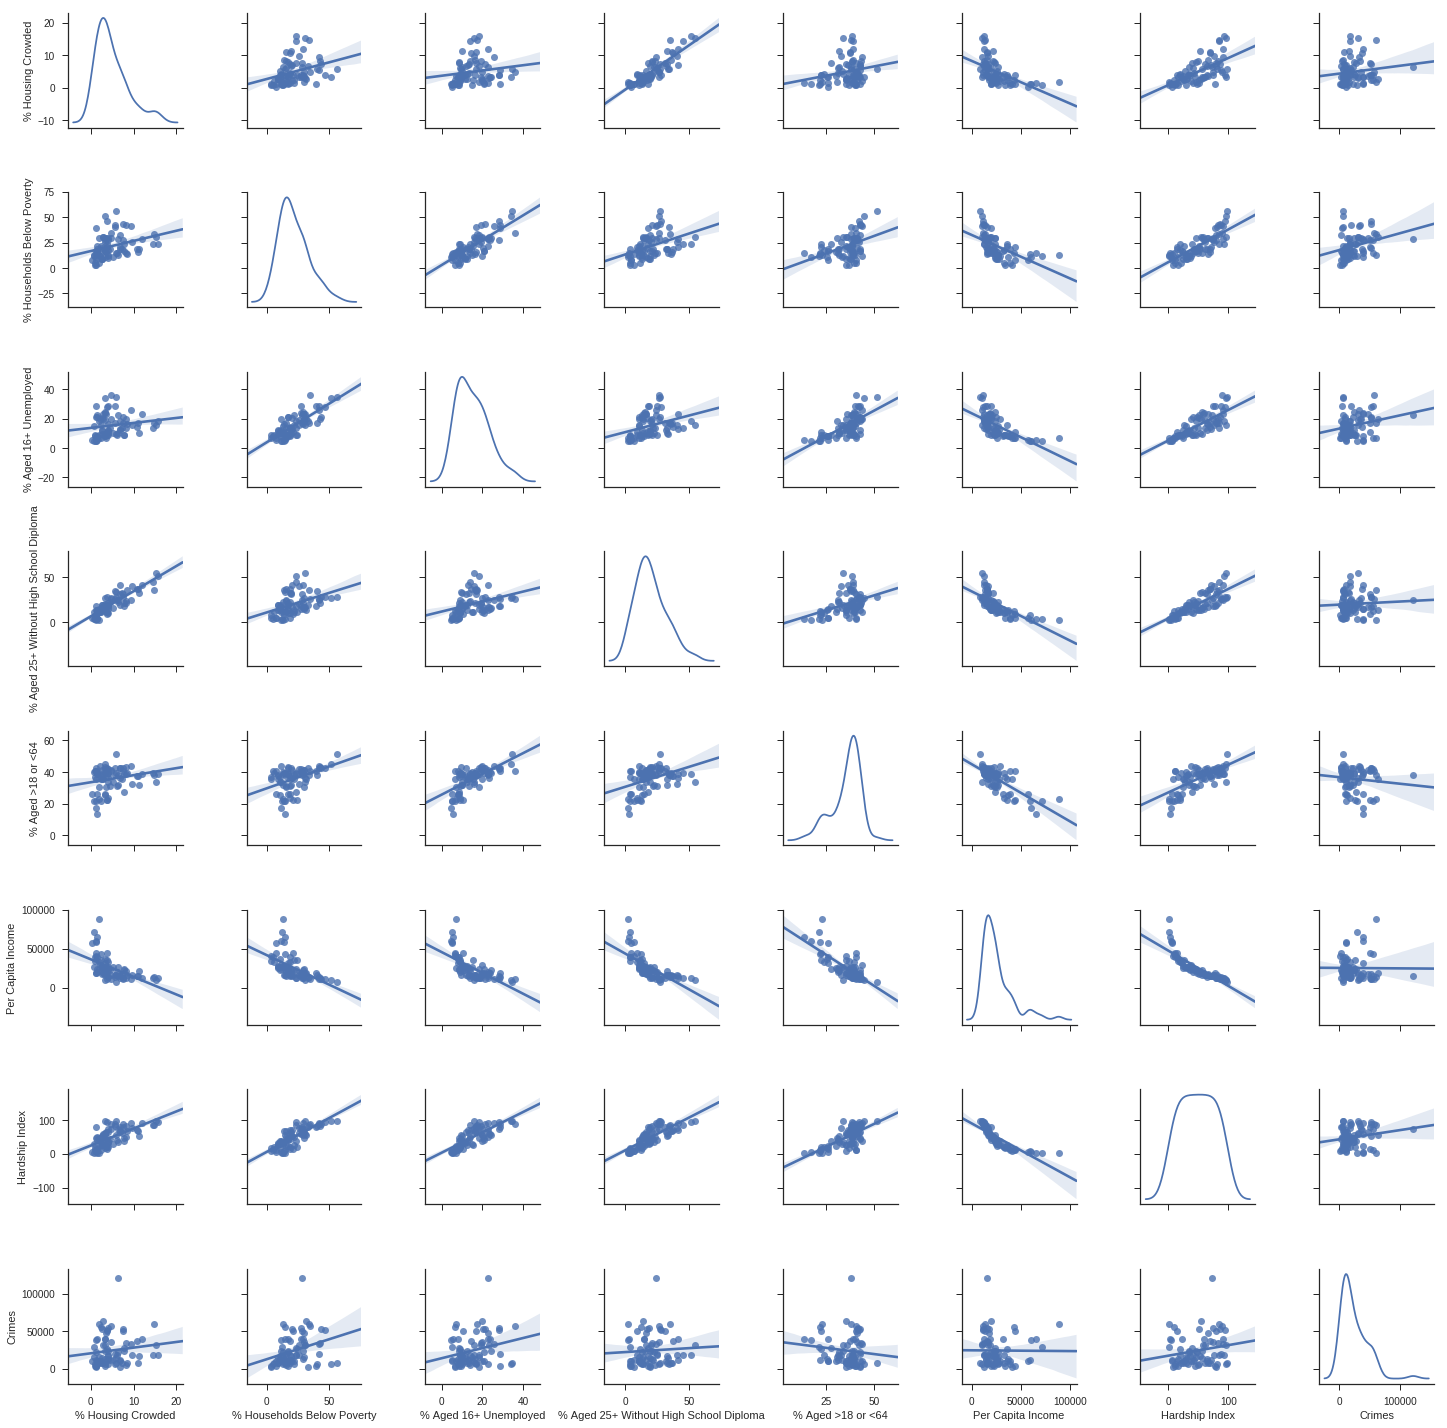

In [22]:
## Pairwise plot showing the relationship trends between independent and dependent variable
# warnings.filterwarnings('ignore')
sns.set(style='ticks', color_codes=True)
sns.pairplot(chicago_crimes_view_df, diag_kind='kde', kind='reg')

In [0]:
chicago_crime_data_grouped = chicago_crime_data_dup.groupby(['Community Area Number', 'Month', 'Primary Type']).size().to_frame('Crimes').reset_index()
# chicago_crime_data_grouped.columns.values

In [24]:
## Merging both the tables for predicting the crime rate
city_data = pd.merge(chicago_crime_data_grouped, chicago_socia_econ, on='Community Area Number', how='inner')

# shape of the dataframe
print(city_data.shape)

## Finding out the missing values in the data
# print(chicago_combined_data.count())
## The above line suggests that there are missing values for Location Description #616 values missing#, Community Area Number #855 values missing#, 
## Hardship Index #885 values missing# ##
# print(chicago_combined_data[chicago_combined_data['Location Description'].isnull()])
# print(chicago_combined_data[chicago_combined_data['Community Area Number'].isnull()].count())
# print(chicago_combined_data[chicago_combined_data['Community Area Number'].isnull() & chicago_combined_data['Hardship Index'].isnull()].count())
# print(chicago_combined_data[chicago_combined_data['Hardship Index'].isnull()].count())
# print(chicago_combined_data[~chicago_combined_data['Community Area Number'].isnull() & chicago_combined_data['Hardship Index'].isnull()])
## There are 30 values missing each for % Housing Crowded, % Households Below Poverty, % Aged 16+ Unemployed, % Aged 25+ Without High School Diploma, 
## % Aged >18 or <64 and Per Capita Income
# print(chicago_combined_data[chicago_combined_data['% Housing Crowded'].isnull()])
# Below 2 lines confirm that there is no information in table chicago_socia_econ for community area number 0.0. Hence, removing this community 
# from the combined data for analysis
# print(chicago_combined_data[chicago_combined_data['% Housing Crowded'].isnull()])
# print(chicago_combined_data[chicago_combined_data['% Housing Crowded'].isnull()].count())

city_data = city_data.dropna(inplace=False)
# Community Area Name is no longer needed for predicting the crime rate. Hence, dropping the column
city_data.drop('Community Area Name', inplace=True, axis=1)

# shape of the dataframe after removing the Nans
print(city_data.shape)

## Shape of the data before and after removing the missing values
###(1876885, 12)
###(1875384, 12)
## Shape of the data before and after the groupby operation
###(20275, 12)
###(20249, 12)

## The no. of rows removed is 0.08 % of the total data and hence is safe to remove the data directly rather than imputing the missing values which may 
## make the data biased

(20249, 12)
(20249, 11)


In [0]:
### We need to convert Community Area Number and Month to categorical type data
city_data['Community Area Number'] = city_data['Community Area Number'].astype('object')
city_data['Month'] = city_data['Month'].astype('object')
city_data['Primary Type'] = city_data['Primary Type'].astype('object')

In [26]:
## One-hot encoding the nominal categorical data
city_data_with_dummies = pd.get_dummies(city_data)
city_data_with_dummies.head(1)

,Crimes,% Housing Crowded,% Households Below Poverty,% Aged 16+ Unemployed,% Aged 25+ Without High School Diploma,% Aged >18 or <64,Per Capita Income,Hardship Index,Community Area Number_1.0,Community Area Number_2.0,...,Primary Type_OTHER NARCOTIC VIOLATION,Primary Type_OTHER OFFENSE,Primary Type_PROSTITUTION,Primary Type_PUBLIC INDECENCY,Primary Type_PUBLIC PEACE VIOLATION,Primary Type_ROBBERY,Primary Type_SEX OFFENSE,Primary Type_STALKING,Primary Type_THEFT,Primary Type_WEAPONS VIOLATION
0,1,7.7,23.6,8.7,18.2,27.5,23939,39.0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
## 1-hot encoding the input attributes for training neural network based model
city_crime_data = city_data_with_dummies.values
X = city_crime_data[:,1:].astype(float) 
Y = city_crime_data[:,0]
## Split for (Train + Validation) and Test
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.20, random_state=123)
## Split for Train + Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.20, random_state=123)

print(city_crime_data.shape)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

### Expected
#(20249, 127)
#(12959, 126)
#(3240, 126)
#(4050, 126)

(20249, 127)
(12959, 126)
(3240, 126)
(4050, 126)


In [0]:
## Normalizing all the continuous attributes

X_train[:,0] = X_train[:,0] / X_train[:,0].max()
X_train[:,1] = X_train[:,1] / X_train[:,1].max()
X_train[:,2] = X_train[:,2] / X_train[:,2].max()
X_train[:,3] = X_train[:,3] / X_train[:,3].max()
X_train[:,4] = X_train[:,4] / X_train[:,4].max()
X_train[:,5] = X_train[:,5] / X_train[:,5].max()
X_train[:,6] = X_train[:,6] / X_train[:,6].max()

X_val[:,0] = X_val[:,0] / X_val[:,0].max()
X_val[:,1] = X_val[:,1] / X_val[:,1].max()
X_val[:,2] = X_val[:,2] / X_val[:,2].max()
X_val[:,3] = X_val[:,3] / X_val[:,3].max()
X_val[:,4] = X_val[:,4] / X_val[:,4].max()
X_val[:,5] = X_val[:,5] / X_val[:,5].max()
X_val[:,6] = X_val[:,6] / X_val[:,6].max()

X_test[:,0] = X_test[:,0] / X_test[:,0].max()
X_test[:,1] = X_test[:,1] / X_test[:,1].max()
X_test[:,2] = X_test[:,2] / X_test[:,2].max()
X_test[:,3] = X_test[:,3] / X_test[:,3].max()
X_test[:,4] = X_test[:,4] / X_test[:,4].max()
X_test[:,5] = X_test[:,5] / X_test[:,5].max()
X_test[:,6] = X_test[:,6] / X_test[:,6].max()

In [32]:
## Building a Neural Network based model for predicting the crime rate

model = Sequential([Dense(64, input_dim=X_train.shape[1], kernel_initializer='glorot_uniform', activation='relu'), 
                  Dense(32, kernel_initializer='glorot_uniform', activation='relu'),
                  Dense(16, kernel_initializer='glorot_uniform', activation='relu'),
                  Dense(8, kernel_initializer='glorot_uniform', activation='relu'),
                  Dense(1, kernel_initializer='glorot_uniform')])
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

Instructions for updating:
Colocations handled automatically by placer.


In [33]:
history = model.fit(X_train, Y_train, batch_size=32, epochs=50, verbose=0, validation_split=.2)

Instructions for updating:
Use tf.cast instead.


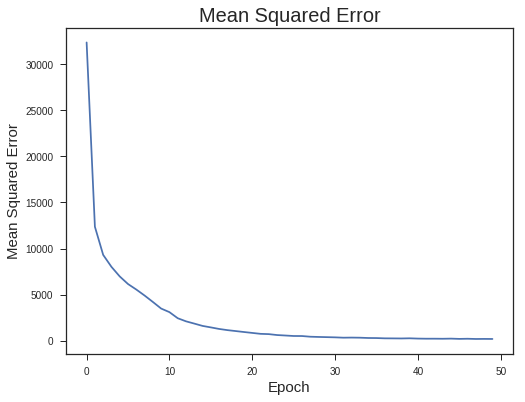

In [37]:
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(history.history['mean_squared_error'])
plt.title('Mean Squared Error', fontsize = 20)
plt.ylabel('Mean Squared Error', fontsize = 15)
plt.xlabel('Epoch', fontsize = 15)
plt.show()

In [38]:
pred_crimes = model.predict(X_test)
mse_pred_score = metrics.mean_squared_error(pred_crimes, Y_test)
print('mse_pred_score {}'.format(mse_pred_score))
rmse_pred_score = np.sqrt(mse_pred_score)
print('rmse_pred_score {}'.format(rmse_pred_score))
r2_pred_score = r2_score(Y_test, pred_crimes, multioutput='uniform_average')  
print('r2_pred_score - Coefficient of Determination {}'.format(r2_pred_score))

mse_pred_score 378.63863012107754
rmse_pred_score 19.45863895859825
r2_pred_score - Coefficient of Determination 0.9879498715498349


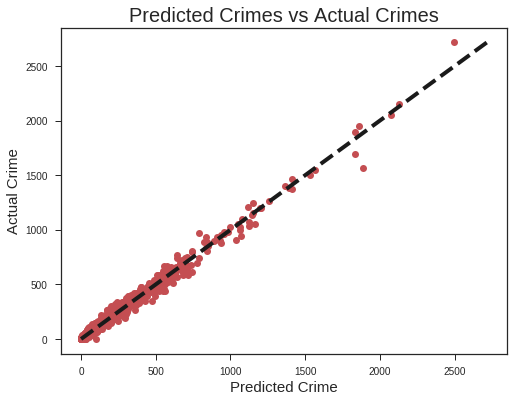

In [39]:
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
fig, ax = plt.subplots(figsize=(8, 6))
plt.style.use('ggplot')
plt.plot(pred_crimes, Y_test, 'ro')
plt.xlabel('Predicted Crime', fontsize = 15)
plt.ylabel('Actual Crime', fontsize = 15)
plt.title('Predicted Crimes vs Actual Crimes', fontsize = 20)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
plt.show()

In [0]:
### Why not make the predictions treating it as a time series data?? Because doing so is wrong. Actually time is not a feature [factor] in this case. 
### There are other factors that actually impact the crime rate and change with time. These include '% Housing Crowded', '% Households Below Poverty',
### '% Aged 16+ Unemployed', '% Aged 25+ Without High School Diploma', '% Aged >18 or <64', 'Per Capita Income', 'Hardship Index'. Given these factors
### we can predict the crime rate for a given month, crime type and community area.

In [0]:
# ## Now, performing the regression using Support Vector Regression

# clf = SVR(kernel='rbf', gamma='auto')
# clf.fit(X_train, Y_train)

In [0]:
# Y_pred_crimes = clf.predict(X_test)
# # mse_pred_score = metrics.mean_squared_error(Y_pred_crimes, Y_test)
# # print('mse_pred_score {}'.format(mse_pred_score))
# # rmse_pred_score = np.sqrt(mse_pred_score)
# # print('rmse_pred_score {}'.format(rmse_pred_score))
# Y_pred_crimes_new = [Y_pred_crimes]
# Y_test_new = [Y_test]
# print(Y_test_new)
# r2_pred_score = clf.score(Y_test_new, Y_pred_crimes_new, sample_weight=None)
# # print('r2_pred_score - Coefficient of Determination {}'.format(r2_pred_score))

In [0]:
city_data_dup = city_data.copy()

In [0]:
## Performing Label Encoding on the data for Grandient Boosting and Random Forest Models
le = LabelEncoder()
city_data_dup['Primary Type'] = le.fit_transform(city_data_dup['Primary Type'])

In [0]:
X = city_data_dup.drop(columns=['Crimes'])
Y = city_data_dup["Crimes"]

## Split for (Train + Validation) and Test
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X, Y, test_size=0.20, random_state=123)
## Split for Train + Validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.20, random_state=123)

# print(X_train.shape)
# print(X_val.shape)
# print(X_test.shape)
# X.head(1)

In [0]:
### Gradient Boosting. Build the model
gb = GradientBoostingRegressor()
model = gb.fit(X_train, Y_train)

In [0]:
# Make predictions on the model
predictions = model.predict(X_test)

In [45]:
## Finding the Root Mean Squared Error and the Coefficient of Determination
mse_pred_score = metrics.mean_squared_error(predictions, Y_test)
print('mse_pred_score {}'.format(mse_pred_score))
rmse_pred_score = np.sqrt(mse_pred_score)
print('rmse_pred_score {}'.format(rmse_pred_score))
r2_pred_score = r2_score(Y_test, pred_crimes, multioutput='uniform_average')  
print('r2_pred_score - Coefficient of Determination {}'.format(r2_pred_score))

mse_pred_score 9494.236726339075
rmse_pred_score 97.43837399268871
r2_pred_score - Coefficient of Determination 0.9879498715498349


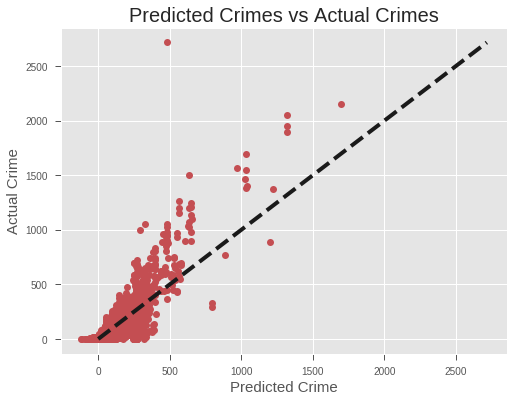

In [46]:
## Plotting the crime predictions
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
fig, ax = plt.subplots(figsize=(8, 6))
plt.style.use('ggplot')
plt.plot(predictions, Y_test, 'ro')
plt.xlabel('Predicted Crime', fontsize = 15)
plt.ylabel('Actual Crime', fontsize = 15)
plt.title('Predicted Crimes vs Actual Crimes', fontsize = 20)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
plt.show()

In [47]:
### Random Forest. Build the model
rf = RandomForestRegressor()
model = rf.fit(X_train, Y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [0]:
# Make predictions on the model
predictions = model.predict(X_test)

In [49]:
## Finding the Root Mean Squared Error and the Coefficient of Determination
mse_pred_score = metrics.mean_squared_error(predictions, Y_test)
print('mse_pred_score {}'.format(mse_pred_score))
rmse_pred_score = np.sqrt(mse_pred_score)
print('rmse_pred_score {}'.format(rmse_pred_score))
r2_pred_score = r2_score(Y_test, pred_crimes, multioutput='uniform_average')  
print('r2_pred_score - Coefficient of Determination {}'.format(r2_pred_score))

mse_pred_score 425.17850617283943
rmse_pred_score 20.61985708420016
r2_pred_score - Coefficient of Determination 0.9879498715498349


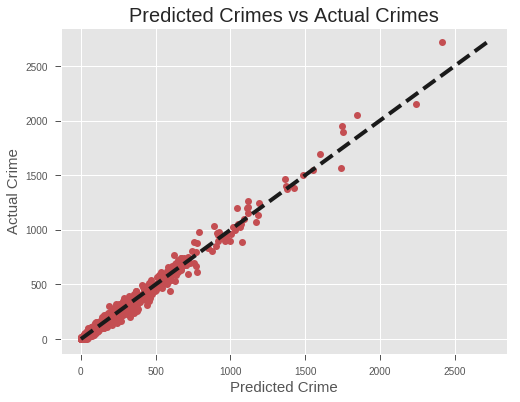

In [50]:
## Plotting the crime predictions
matplotlib.rc('xtick', labelsize=10) 
matplotlib.rc('ytick', labelsize=10) 
fig, ax = plt.subplots(figsize=(8, 6))
plt.style.use('ggplot')
plt.plot(predictions, Y_test, 'ro')
plt.xlabel('Predicted Crime', fontsize = 15)
plt.ylabel('Actual Crime', fontsize = 15)
plt.title('Predicted Crimes vs Actual Crimes', fontsize = 20)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
plt.show()